In [1]:
from astropy.io import fits
from astropy import wcs
import regions

In [2]:
import crowdsource

In [3]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [4]:
from astropy.io import fits

In [5]:
from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod
from webbpsf.utils import to_griddedpsfmodel

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick/'

In [8]:
import sys
sys.path.append(f'{basepath}/analysis')
import crowdsource_catalogs_long
from crowdsource_catalogs_long import WrappedPSFModel

Starting crowdsource_catalogs_long
Importing webbpsf
2024-06-30T13:58:00.727493: Done with imports


In [9]:
import glob
import time
import numpy
import crowdsource
import regions
import numpy as np
from functools import cache
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import wcs
from astropy import table
from astropy import stats
from astropy import units as u
from astropy.nddata import NDData
from astropy.io import fits
from scipy import ndimage
import requests
import requests.exceptions
import urllib3
import urllib3.exceptions
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, extract_stars, EPSFStars, EPSFModel
try:
    # version >=1.7.0, doesn't work: the PSF is broken
    from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
except:
    # version 1.6.0, which works
    from photutils.psf import BasicPSFPhotometry as PSFPhotometry, IterativelySubtractedPSFPhotometry as IterativePSFPhotometry, DAOGroup as SourceGrouper
try:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D, LocalBackground
except:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D
    from photutils.background import MMMBackground as LocalBackground

from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

import warnings
from astropy.utils.exceptions import AstropyWarning, AstropyDeprecationWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyDeprecationWarning)

from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

from astroquery.svo_fps import SvoFps

import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

import os
print("Importing webbpsf", flush=True)
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
import datetime


Importing webbpsf


In [10]:
cd /orange/adamginsburg/jwst/brick/images

/blue/adamginsburg/adamginsburg/jwst/brick/images


In [11]:
fh_410 = fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged_i2d.fits')
# how does this work on indiv snapshots?
#fh = fits.open('/blue/adamginsburg/adamginsburg/jwst/brick/F410M/pipeline/jw02221001001_07101_00001_nrcalong_cal.fits')
im1 = fh
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']
ww = wcs.WCS(fh['SCI'].header)

wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
obsdate = im1[0].header['DATE-OBS']

In [12]:
# data = fh[1].data[1383:1883, 2344:2844]
# CANNOT use cutouts with new PSF model
data = fh[1].data

In [13]:
from astropy import stats
stats.mad_std(data), stats.sigma_clip(data).std()

(7.982590245489876, 7.103870999925948)

In [14]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
with open(os.path.expanduser('~/.mast_api_token'), 'r') as fh:
    os.environ['MAST_API_TOKEN'] = fh.read().strip()
import webbpsf

In [15]:
import numpy as np
from scipy import ndimage

# load psf

In [16]:
filtername = 'f410m'
proposal_id = '2221'
field = '001'
grid = psfgrid = to_griddedpsfmodel(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample1.fits')
grid_blur = psfgrid_blur = to_griddedpsfmodel(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample1_blur.fits')
psf_model = WrappedPSFModel(grid)
psf_model_blur = WrappedPSFModel(grid_blur)

In [62]:
grid.flux.min = 0
grid.flux

Parameter('flux', value=1.0, bounds=(0.0, None))

In [17]:
err = im1['ERR'].data
if 'WHT' in im1:
    wht = im1['WHT'].data
else:
    wht = 1

# crowdsource uses inverse-sigma, not inverse-variance
weight = err**-1
maxweight = np.percentile(weight[np.isfinite(weight)], 95)
minweight = np.percentile(weight[np.isfinite(weight)], 5)
badweight =  np.percentile(weight[np.isfinite(weight)], 1)
weight[err < 1e-5] = 0
#weight[(err == 0) | (wht == 0)] = np.nanmedian(weight)
weight[np.isnan(weight)] = 0
bad = np.isnan(weight) | (data == 0) | np.isnan(data) | (weight == 0) | (err == 0) | (wht == 0) | (data < 1e-5)

weight[weight > maxweight] = maxweight
weight[weight < minweight] = minweight
# it seems that crowdsource doesn't like zero weights
# may have caused broked f466n? weight[bad] = badweight
weight[bad] = minweight
# crowdsource explicitly handles weight=0, so this _should_ work.
weight[bad] = 0


dq = np.zeros(data.shape, dtype='int')
bad_for_dq = ndimage.binary_dilation(bad, iterations=2)
dq[bad_for_dq] = 2 | 2**30 | 2**31

/scratch/local/33675441/ipykernel_1391698/866616023.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  weight = err**-1


In [18]:
reg = regions.Regions.read(f'{basepath}/regions_/leftside_brick_rezoom.reg')[0]
mask = reg.to_pixel(ww).to_mask()
slcs,_ = mask.get_overlap_slices(fh_410['SCI'].data.shape[:2])
co = fh_410['SCI'].data[slcs]
weight_co = weight[slcs]
dq_co = dq[slcs]

In [19]:
bg_boxsizes={'f182m': 19, 'f187n':11, 'f212n':11,
             'f410m': 11, 'f405n':11, 'f466n':11,
             'f444w': 11, 'f356w':11,
             'f200w':19, 'f115w':19,
            }

In [20]:
fwhm_pix = 2.179
grouper = SourceGrouper(2 * fwhm_pix)
mmm_bkg = MMMBackground()

filtered_errest = stats.sigma_clipped_stats(data, stdfunc='mad_std')
print(f'Error estimate for DAO from stats.: {filtered_errest}', flush=True)
filtered_errest = np.nanmedian(err)
print(f'Error estimate for DAO from median(err): {filtered_errest}', flush=True)

daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                              sharplo=0.30, sharphi=1.40)

Error estimate for DAO from stats.: (11.2913065, 10.591381, 6.72341)
Error estimate for DAO from median(err): 0.15106038749217987


In [21]:
all_results = {}
for bgsub in (True, False):
    data = co
    if bgsub:
        bkg = Background2D(data, box_size=bg_boxsizes[filt.lower()], bkg_estimator=MedianBackground())

        # subtract background, but then re-zero the edges
        zeros = data == 0
        data = data - bkg.background
        data[zeros] = 0

    for blur, daopsf, cspsf in zip((True, False), (grid_blur, grid), (psf_model_blur, psf_model)):
        crowdsource_results  = fit_im(np.nan_to_num(data), cspsf, weight=weight_co,
                                      dq=dq_co,
                                      nskyx=0, nskyy=0, verbose=False)
        stars, modsky, skymsky, psf_ = crowdsource_results
        stars = Table(stars)
        stars['x'], stars['y'] = stars['y'], stars['x']
        all_results[(bgsub, blur, 'crowdsource')] = stars
        
        phot = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                             #grouper=grouper,
                             #localbkg_estimator=None, # must be none or it un-saturates pixels
                             localbkg_estimator=LocalBackground(5, 15),
                             psf_model=daopsf,
                             fitter=LevMarLSQFitter(),
                             fit_shape=(5, 5),
                             aperture_radius=2*fwhm_pix,
                             #progress_bar=True,
                            )
        
        result = phot(np.nan_to_num(data))
        all_results[(bgsub, blur, 'dao_basic')] = result
        
        phot_ = IterativePSFPhotometry(finder=daofind_tuned,
                                       localbkg_estimator=LocalBackground(5, 15),
                                       psf_model=daopsf,
                                       fitter=LevMarLSQFitter(),
                                       maxiters=2,
                                       fit_shape=(5, 5),
                                       aperture_radius=2*fwhm_pix,
                                       #progress_bar=True
                                      )
        result = phot(np.nan_to_num(data))
        all_results[(bgsub, blur, 'dao_iterative')] = result

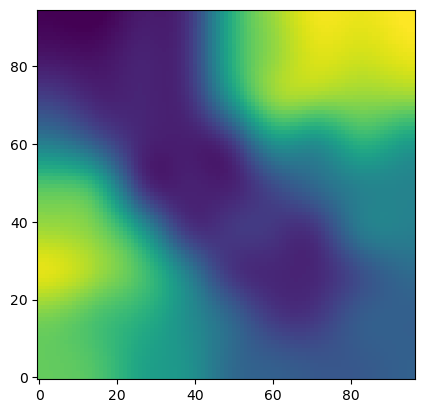

In [22]:
pl.imshow(bkg.background)

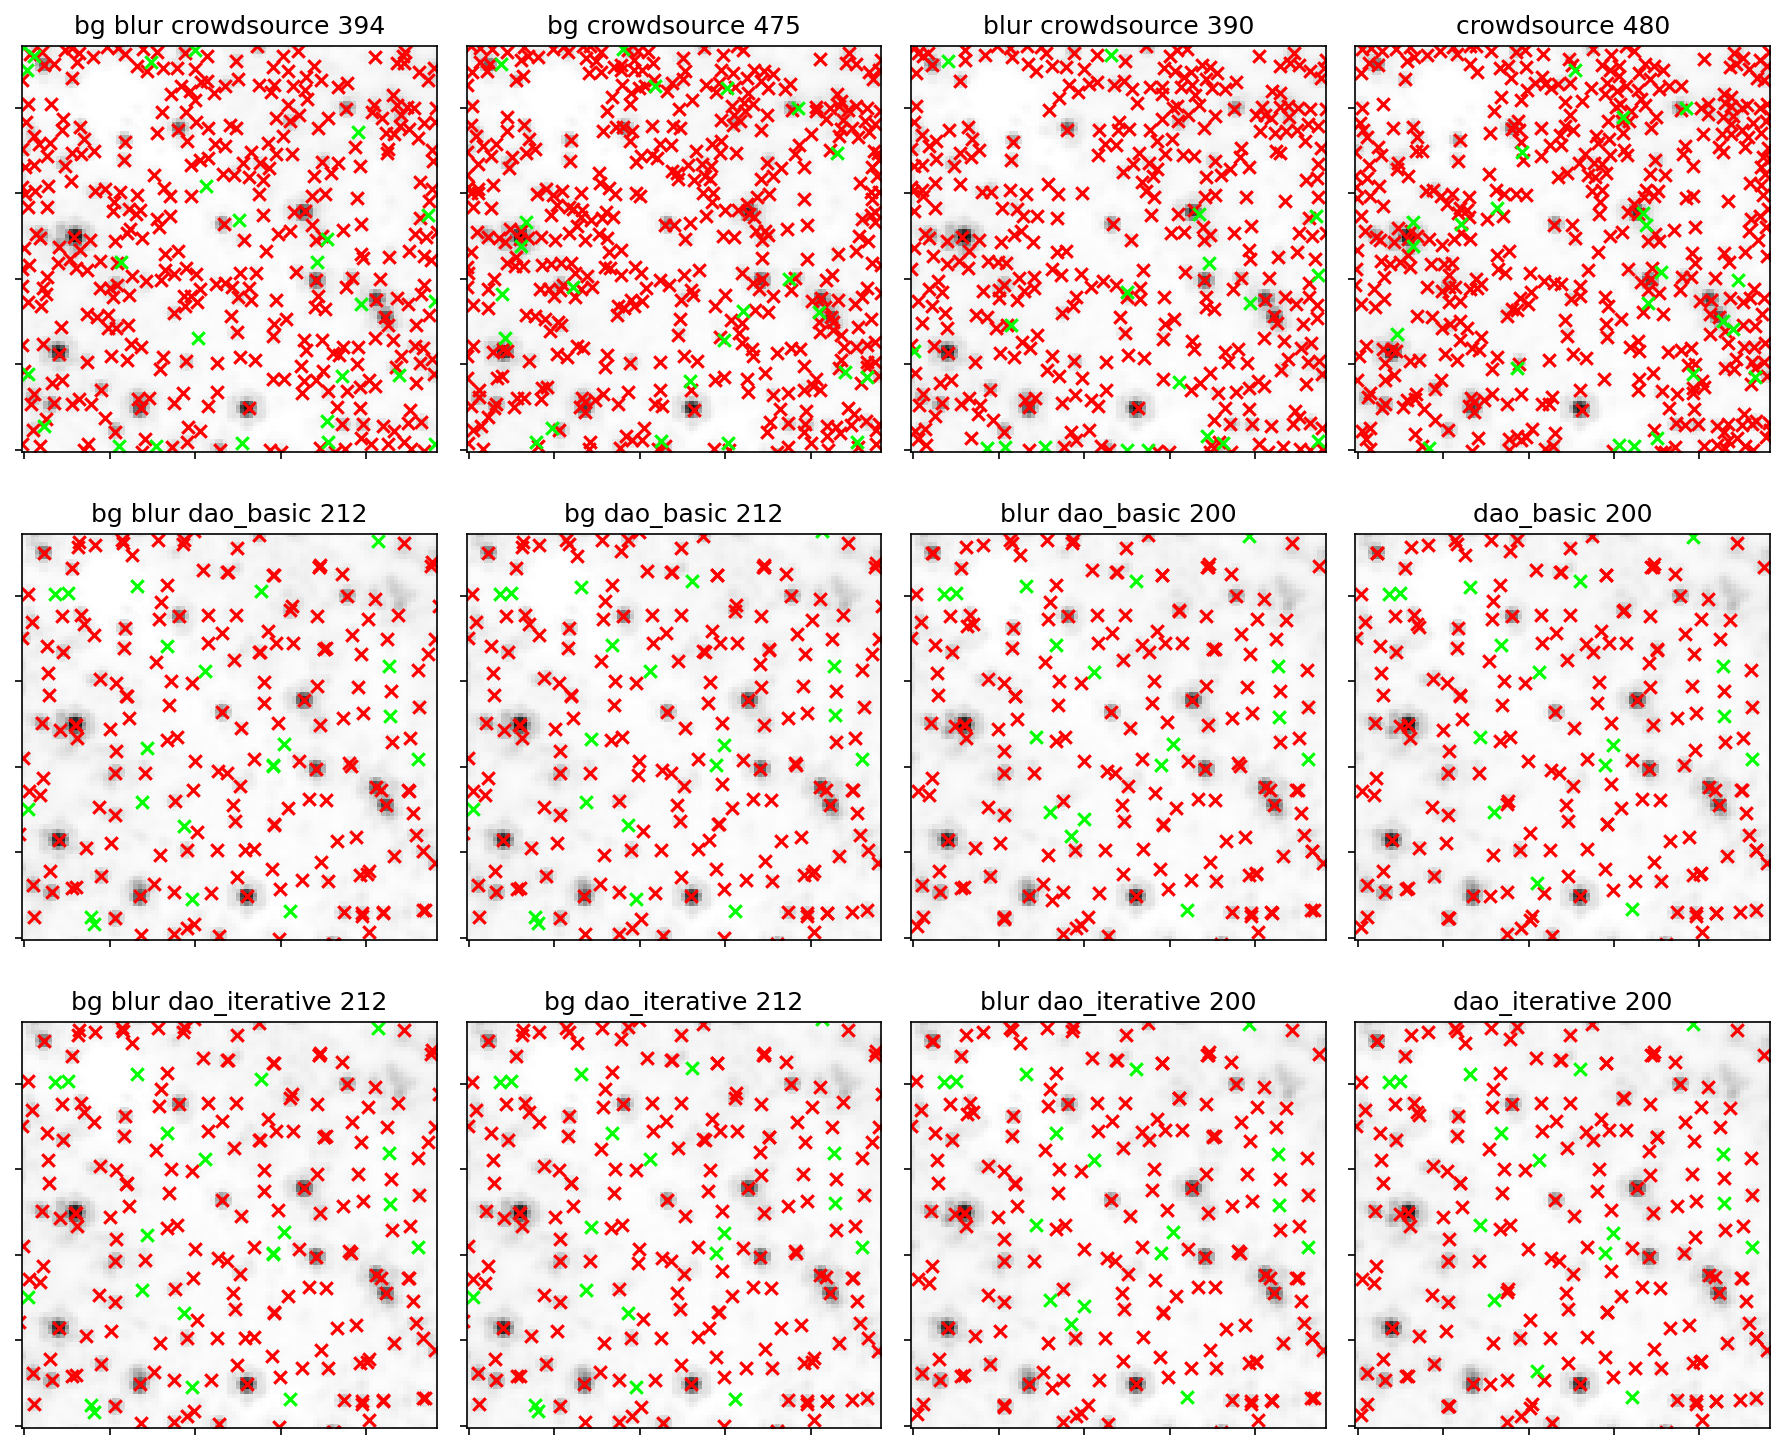

In [23]:
fig1 = pl.figure(figsize=(12,10), dpi=150)

for ii, ((bgsub, blur, alg), result) in enumerate(all_results.items()):
    ind = ((ii) % 3 * 4 + ii // 3 ) + 1
    ax1 = fig1.add_subplot(3, 4, ind)
    ax1.imshow(data, cmap='gray_r', norm=simple_norm(data, stretch='asinh', min_percent=1, max_percent=99.995), origin='lower')
    lims = ax1.axis()
    if 'x' in result.colnames:
        pos = result['flux'] > 0
        ax1.scatter(result['x'][pos], result['y'][pos], color='r', marker='x')
        ax1.scatter(result['x'][~pos], result['y'][~pos], color='lime', marker='x')
    elif 'x_fit' in result.colnames:
        pos = result['flux_fit'] > 0
        ax1.scatter(result['x_fit'][pos], result['y_fit'][pos], color='r', marker='x')
        ax1.scatter(result['x_fit'][~pos], result['y_fit'][~pos], color='lime', marker='x')
    ax1.set_title(f'{"bg " if bgsub else ""}{"blur " if blur else ""}{alg} {len(result)}')
    ax1.axis(lims)

    pl.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        labelleft=False,
        labelbottom=False) 
    
pl.tight_layout()

In [24]:
((np.arange(12)) % 3 * 4 + np.arange(12) // 3 ) + 1

array([ 1,  5,  9,  2,  6, 10,  3,  7, 11,  4,  8, 12])

In [25]:
np.arange(12) // 4

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

In [26]:
(np.arange(12)) % 3 * 4

array([0, 4, 8, 0, 4, 8, 0, 4, 8, 0, 4, 8])

## Crossmatch: Compare bgsub to non-bgsub

In [27]:
from scipy.spatial import KDTree

In [28]:
((np.arange(12)) % 3 * 2 + np.arange(12) // 3 ) + 1

array([1, 3, 5, 2, 4, 6, 3, 5, 7, 4, 6, 8])

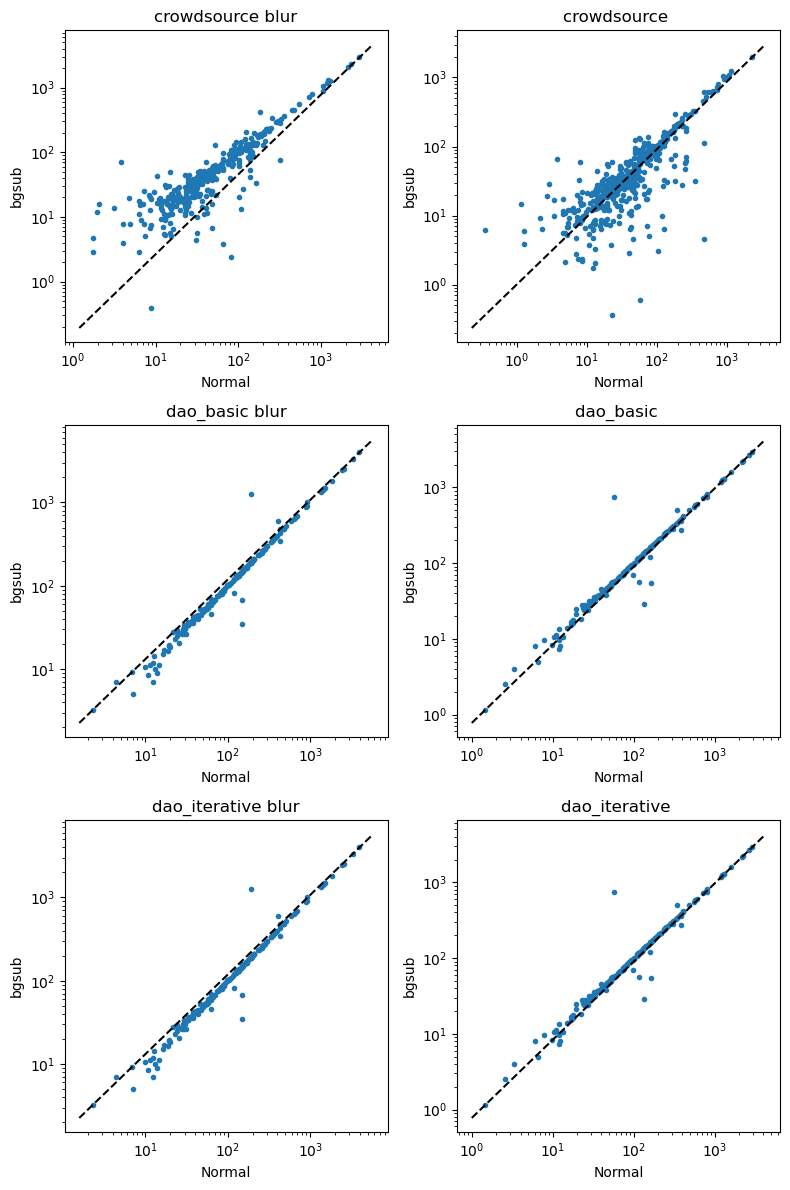

In [29]:
pl.figure(figsize=(8,12))
for ii, ((bgsub, blur, alg), result) in enumerate(all_results.items()):
    if bgsub:
        ind = ((ii) % 3 * 2 + ii // 3 ) + 1
        ax = pl.subplot(3, 2, ind)
        result_sub = all_results[(False, blur, alg)]
        if alg == 'crowdsource':
            dist, idx = np.array(KDTree(np.array([result['x'], result['y']]).T).query(np.array([result_sub['x'], result_sub['y']]).T))
            idx = idx.astype('int')
            
            ax.loglog(result['flux'][idx[dist < 3]], result_sub['flux'][dist < 3], '.')
        else:
            dist, idx = np.array(KDTree(np.array([result['x_fit'], result['y_fit']]).T).query(np.array([result_sub['x_fit'], result_sub['y_fit']]).T))
            idx = idx.astype('int')
        
            ax.loglog(result['flux_fit'][idx[dist < 3]], result_sub['flux_fit'][dist < 3], '.')
        lims = ax.axis()
        ax.set_xlabel("Normal")
        ax.set_ylabel("bgsub")
        ax.set_title(f'{alg} {"blur" if blur else ""}')
        ax.plot(lims[:2], lims[-2:], 'k--')
pl.tight_layout()

In [30]:
tb = all_results[(False, False, 'crowdsource')]
dist, idx = np.array(KDTree(np.array([result['x_fit'], result['y_fit']]).T).query(np.array([tb['x'], tb['y']]).T))
idx = idx.astype('int')

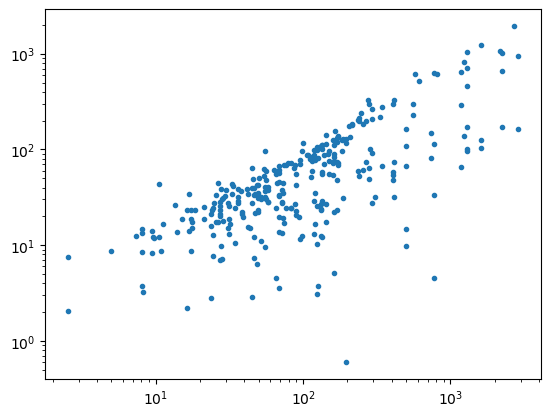

In [31]:
pl.loglog(result['flux_fit'][idx[dist < 3]], tb['flux'][dist < 3], '.')

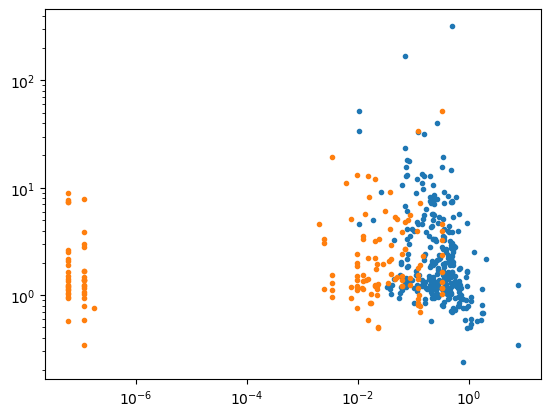

In [32]:
pl.loglog(result['qfit'][idx[dist<3]], result['flux_fit'][idx[dist<3]]/tb['flux'][dist<3], '.')
pl.loglog((1-tb['qf'])[dist<3], result['flux_fit'][idx.astype('int')[dist<3]]/tb['flux'][dist<3], '.')

In [33]:
len(result), len(tb)

(200, 480)

In [34]:
np.where([result['flux_fit'] < 0])[1]

array([ 11,  29,  61,  86,  89,  94, 100, 112, 127, 129, 145, 167, 170,
       171, 173, 197])

In [38]:
phot._fit_model_params[phot._fit_model_params['flux']>0]

id,flux,x_0,y_0
int64,float64,float64,float64
1,359.1857149539389,21.254228274647453,4.570804894425964
2,502.8787330323176,72.13138953980173,-1.400362144042925
3,28.39393668886292,0.780268045363673,2.580940126514626
4,135.0777721617071,35.08211739239924,0.9002892856576235
5,294.72978269251007,45.54218085490817,0.524101285227678
6,33.70898215566235,80.66507612656186,1.3104640929275853
7,119.31799868408247,38.214358920525164,2.285670474085579
8,82.08047906359074,83.78858224412767,5.82642990139585
9,134.18096723571432,2.2729066740463546,4.968794127885134


In [ ]:
len([mod for mod, ok in zip(phot._fit_models, result['flux_fit'] > 0) if ok])

In [ ]:
phot.make_model_image??

In [ ]:
[mod for mod, ok in zip(phot._fit_models, result['flux_fit'] > 0) if ok]

In [ ]:
x = list(range(10))
x[0,1,2

In [44]:
phot_

In [52]:
phot_(data)

id,group_id,group_size,iter_detected,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
1,1,1,1,8.702000617980957,21.267814085748466,2.0870187997928067,697.209069447544,21.254228274647453,4.570804894425964,359.1857149539389,0.024179811169810793,0.0488577307923361,13.584730033727155,25,0.049074177372621514,0.0037118750404879336,0
2,2,1,1,7.786762237548828,72.16404361659302,0.38115844630569307,371.0876014619725,72.13138953980173,-1.400362144042925,502.8787330323176,0.022700572424867616,0.07293342511975338,53.581625673028796,15,0.010640465660356643,0.000461557290026509,3
3,3,1,1,9.115004539489746,1.0817630783276546,1.4700997610817657,387.3970037199045,0.780268045363673,2.580940126514626,28.39393668886292,nan,nan,nan,16,0.427023592009012,-0.0069804925732118005,9
4,4,1,1,8.34936237335205,35.07617180394785,1.0344598778569793,495.266347759867,35.08211739239924,0.9002892856576235,135.0777721617071,0.09382070458003457,0.10202137512077412,9.090114666928088,20,0.1620487426822838,-0.007551758904427664,1
5,5,1,1,7.721339225769043,45.54343758800978,0.69985542747695,515.1984284543992,45.54218085490817,0.524101285227678,294.72978269251007,0.02127562610311565,0.02521607421078863,4.734698936556082,20,0.04518905578556578,-0.0014557725842537026,1
6,6,1,1,8.345824241638184,80.66951829096593,1.2304674204845727,424.900593833813,80.66507612656186,1.3104640929275853,33.70898215566235,0.12968013238056172,0.13336110446655428,3.2335188079827892,20,0.330989389708644,-0.004207592935999857,1
7,7,1,1,7.886724948883057,38.22588164936655,2.199507798079047,596.1820490587501,38.214358920525164,2.285670474085579,119.31799868408247,0.16401299135796762,0.16538564473003292,14.26072925832977,25,0.3496524349324671,-0.014663303481425154,0
8,8,1,1,8.371073722839355,85.39118961205511,4.0966725240665545,581.0041111961937,83.78858224412767,5.82642990139585,82.08047906359074,0.12236003689842864,0.14692086719995043,7.077878580155423,25,0.27390176040376646,0.008473972928042708,0
9,9,1,1,9.73525619506836,2.2949265430443133,4.93737133220739,616.40399192474,2.2729066740463546,4.968794127885134,134.18096723571432,0.05190273127427535,0.05422336158984565,5.114916276695732,25,0.15362640703895658,-0.00579618987098445,0


In [59]:
#phot_._psfphot.fit_results.keys()b
phot_.fit_results[0]._fit_model_params

id,flux,x_0,y_0
int64,float64,float64,float64
1,359.1857149539389,21.254228274647453,4.570804894425964
2,502.8787330323176,72.13138953980173,-1.400362144042925
3,28.39393668886292,0.780268045363673,2.580940126514626
4,135.0777721617071,35.08211739239924,0.9002892856576235
5,294.72978269251007,45.54218085490817,0.524101285227678
6,33.70898215566235,80.66507612656186,1.3104640929275853
7,119.31799868408247,38.214358920525164,2.285670474085579
8,82.08047906359074,83.78858224412767,5.82642990139585
9,134.18096723571432,2.2729066740463546,4.968794127885134
